In [36]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import cyipopt as ipopt
import cplex

### 1. Implement the investment strategies

In [37]:
# Buy and hold strategy
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

# Equally weighted
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    # Calculate total asset
    total_asset = np.dot(cur_prices, x_init) + cash_init
    # Equally allocate money to 20 stocks
    allocation = np.ones((20)) * total_asset / 20
    # round down
    x_optimal = np.floor(allocation/cur_prices)
    tran_fee = 0.005*np.dot(cur_prices , abs(x_optimal-x_init))
    cash_optimal = total_asset - tran_fee - np.dot(x_optimal, cur_prices)
    return x_optimal, cash_optimal

# Min variance strategy
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    n = 20 # 20 stocks
    total_asset = np.dot(cur_prices, x_init) + cash_init
    
    cpx = cplex.Cplex() 
    # set objective function
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # get columns
    cols = []
    for i in range(n):
        cols.append([[0,1],[1,0]])
    var_names = [f"w_{i}" for i in range(1, n + 1)]
    # constraint the sum of weights
    cpx.linear_constraints.add(rhs=[1.0, 0], senses='EG')
    # set the coeffients and bounds
    cpx.variables.add(obj=[0.0] * n, ub=[1.0] * n, lb=[0.0] * n, 
                      columns = cols, names=var_names)
    
    # define quadratic part
    q_matrix = [[list(range(n)),list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(q_matrix) 
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None) 
    cpx.solve()
    
    # compute weight matrix
    w_minVar = cpx.solution.get_values() 
    
    allocation = np.array(w_minVar) * total_asset   
    x_optimal = np.floor(allocation / cur_prices)  
    
    tran_fee = np.dot(cur_prices, abs(x_optimal - x_init)) * 0.005
    
    # Calculate the cash_optimal value
    cash_optimal = total_asset - tran_fee - np.dot(x_optimal, cur_prices)
    
    return x_optimal, cash_optimal

# Maximum Sharpe ratio strategy
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):

    total_asset = cur_prices.dot(x_init) + cash_init
    
    if cur_year == 2008:
        r_rf = 0.045
    elif cur_year == 2022:
        r_rf = 0.0375
    else:
        r_rf = 0.025
    daily_rf = r_rf / 252
    
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q2 = np.vstack([Q1,np.zeros((21))])  
    diff = mu-daily_rf * np.ones(20) 
    cpx = cplex.Cplex()  
    #set sense to minimize objective
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    A = []
    for i in range(20):
        A.append([[0,1],[diff[i],1.0]])
    A.append([[0,1],[0,-1.0]]) 
    var_names = ['y_%s'% i for i in range(1,22)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE') 
    cpx.variables.add(obj=[0]*21,lb=[0]*21,ub=[np.inf]*21,columns=A,names=var_names)
    Qmat = [[list(range(21)),list(2*Q2[k,:])] for k in range(21)]
    #set quadratic objective
    cpx.objective.set_quadratic(Qmat)
    alg = cpx.parameters.lpmethod.values  
    cpx.parameters.qpmethod.set(alg.concurrent) 
    #disable the print of results and warnings
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    #optimize the problem
    cpx.solve()
    if cpx.solution.get_status_string()== 'infeasible':
      x_optimal = x_init
      cash_optimal = cash_init
      w_maxSharp = (x_init*cur_prices)/total_asset
    else:
      w = np.array(cpx.solution.get_values())
      w = w[0:20]/w[20]

      allocation = w * total_asset
      # round down
      x_optimal = np.floor(allocation / cur_prices) 
      tran_fee = np.dot(cur_prices, abs(x_optimal-x_init))*0.005
      cash_optimal = total_asset - np.dot(cur_prices,x_optimal) - tran_fee

    return x_optimal, cash_optimal

In [38]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    total_asset = np.dot(cur_prices, x_init) + cash_init
    
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            # Insert your gradient computations here
            y = x * np.dot(Q,x)
            # You can use finite differences to check the gradient
            for i in range(20):
                for j in range(20):
                    d1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i])
                    d2 = Q[i,j] * x[i]
                    delta_g = (y[i]-y[j]) * (d1 - d2)
                    grad[i] = grad[i] + delta_g
                grad[i] = grad[i] + delta_g
            return grad

        def constraints(self, x):
            # The callback for calculating the constraints
            return [1.0] * n
    
        def jacobian(self, x):
            # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
        

    n=20 # 20 stocks
    w0 = [1.0/n]*n
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level'.encode('utf-8'),0)
    
    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    allocation = w_erc * total_asset
    # round down
    x_optimal = np.floor(allocation / cur_prices) 

    tran_fee = np.dot(cur_prices, abs(x_optimal-x_init))*0.005
    cash_optimal = total_asset - np.dot(cur_prices,x_optimal) - tran_fee
    return x_optimal, cash_optimal

In [39]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    #Use IPOPT solver to calculate equal risk contribution
    class erc(object):
        def __init__(self):
            pass

        def objective(self, x):
            # The callback for calculating the objective
            y = x * np.dot(Q, x)
            fval = 0
            for i in range(n):
                for j in range(i,n):
                    xij = y[i] - y[j]
                    fval = fval + xij*xij
            fval = 2*fval
            return fval

        def gradient(self, x):
            # The callback for calculating the gradient
            grad = np.zeros(n)
            y = x * np.dot(Q, x)
            # Insert your gradient computations here
            for i in range(n):
                for j in range(n):
                    diff1 = np.dot(Q[i],x) + np.dot(Q[i][i],x[i])
                    diff2 = np.dot(Q[i][j], x[i])
                    delta_g = (y[i]-y[j]) * (diff1 - diff2)
                    grad[i] = grad[i] + delta_g
                grad[i] = 2 * 2 * grad[i]
            # You can use finite differences to check the gradient
            return grad

        def constraints(self, x):
        # The callback for calculating the constraints
            return [1.0] * n
        def jacobian(self, x):
        # The callback for calculating the Jacobian
            return np.array([[1.0] * n])
    
    total_asset = np.sum(x_init*cur_prices) + cash_init
    if cur_year == 2008:
        r_rf = 0.045
    elif cur_year == 2022:
        r_rf = 0.0375
    else:
        r_rf = 0.025
    borrow_money = init_value
    
    interest = borrow_money*(r_rf/6)
    
    if period == 1:
        total_asset += borrow_money
    
    n = 20
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    w0 = (x_init*cur_prices)/total_asset
    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level'.encode('utf-8'),0)
    w_lerc, info = nlp.solve(w0)
    w_lerc = np.asarray(w_lerc)
    w_lerc = w_lerc*(1/w_lerc.sum())
    
    allocation = w_lerc * total_asset
    # round down
    x_optimal = np.floor(allocation / cur_prices) 
    tran_fee = np.dot(cur_prices, abs(x_optimal-x_init))*0.005
    cash_optimal = total_asset - np.dot(cur_prices,x_optimal) - tran_fee
    
    return x_optimal, cash_optimal

In [40]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    total_asset = np.dot(cur_prices, x_init) + cash_init
    interest = 0
    
    w0 = [1/20]*20
    ret_init = np.dot(mu, w0)
    var_init = np.dot(w0, np.dot(Q, w0))
    
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd = rob_init
    
    if cur_year == 2008:
        r_rf = 0.045
    elif cur_year == 2022:
        r_rf = 0.0375
    else:
        r_rf = 0.025
    daily_rf = r_rf / 252
    #calculate daily risk-free rate
    daily_r_rf = r_rf/252
    
    Portf_Retn = daily_r_rf
    
    A = []
    for k in range(20):
        A.append([[0,1],[1.0,mu[k]]])
    
    cpx = cplex.Cplex()
    #set sense to minimize objective
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    var_names = ["w_%s" % i for i in range(1,21)]
    cpx.variables.add(obj=[0.0]*20,lb=[0.0] * 20, ub=[1.0] * 20, columns=A,names=var_names)
    Qmatrix = [[list(range(20)), list(2*Q[k,:])] for k in range(20)]
    cpx.objective.set_quadratic(Qmatrix)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(20), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
    
    else:
        w_rMV = np.array(cpx.solution.get_values())
        w_rMV[w_rMV<1e-6] = 0 
        w_optimal = w_rMV / np.sum(w_rMV)
        allocation = w_optimal * total_asset
        # round down
        x_optimal = np.floor(allocation / cur_prices) 
        tran_fee = np.dot(cur_prices, abs(x_optimal-x_init))*0.005
        cash_optimal = total_asset - np.dot(cur_prices,x_optimal) - tran_fee
    
    return x_optimal, cash_optimal

In [41]:
# Input file
input_file_prices ='Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [42]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs
    
      while cash[strategy, period-1] < 0:
            # total asset before balancing
            total_asset = np.dot(cur_prices, curr_positions) + curr_cash
            # current weight
            weight = x[strategy][period-1]/np.sum(x[strategy][period-1])
            cash_balance = abs(cash[strategy, period-1])*weight
            x[strategy][period-1] = x[strategy][period-1]- np.ceil(cash_balance/cur_prices) # round up
            # new transaction fee
            tran_fee_new = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = total_asset - np.dot(cur_prices,x[strategy, period-1]) - tran_fee_new
        
    
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################


Initial portfolio value = $ 1000013.0


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000013.00, value end = $ 893956.82
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.24, value end = $ 893208.59
  Strategy "Mininum Variance Portfolio", value begin = $ 992758.41, value end = $ 916240.12
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.37, value end = $ 922095.98
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991537.08, value end = $ 898332.69
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 990197.08, value end = $ 927867.87
  Strategy "Robust Optimization Portfolio", value begin = $ 992214.57, value end = $ 917833.69

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931395.29, value end = $ 862353.83
  Strategy "Mininu

  Strategy "Mininum Variance Portfolio", value begin = $ 1054688.50, value end = $ 1048743.13
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2113787.35, value end = $ 2217141.21
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1464929.30, value end = $ 1517795.39
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1506737.42, value end = $ 1560987.14
  Strategy "Robust Optimization Portfolio", value begin = $ 1358187.47, value end = $ 1388305.01


### 2. Analyze your result

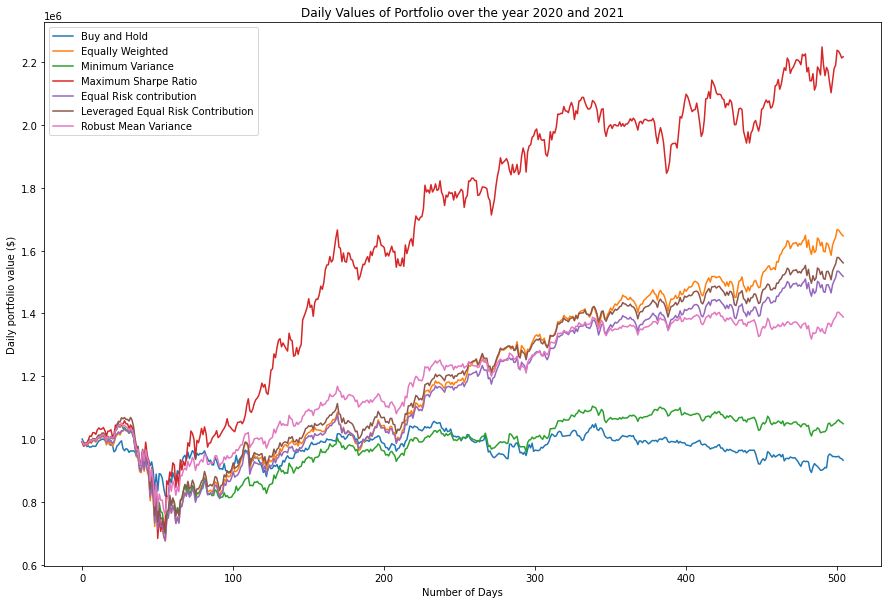

In [43]:
#Plot the daily value of the portfolio
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(portf_value[0], label='Buy and Hold')
ax.plot(portf_value[1], label='Equally Weighted')
ax.plot(portf_value[2], label='Minimum Variance')
ax.plot(portf_value[3], label='Maximum Sharpe Ratio')
ax.plot(portf_value[4],label='Equal Risk contribution')
ax.plot(portf_value[5],label='Leveraged Equal Risk Contribution')
ax.plot(portf_value[6],label='Robust Mean Variance')
ax.set_title('Daily Values of Portfolio over the year 2020 and 2021')
ax.set_xlabel('Number of Days')
ax.set_ylabel('Daily portfolio value ($)')
ax.legend()
plt.show()

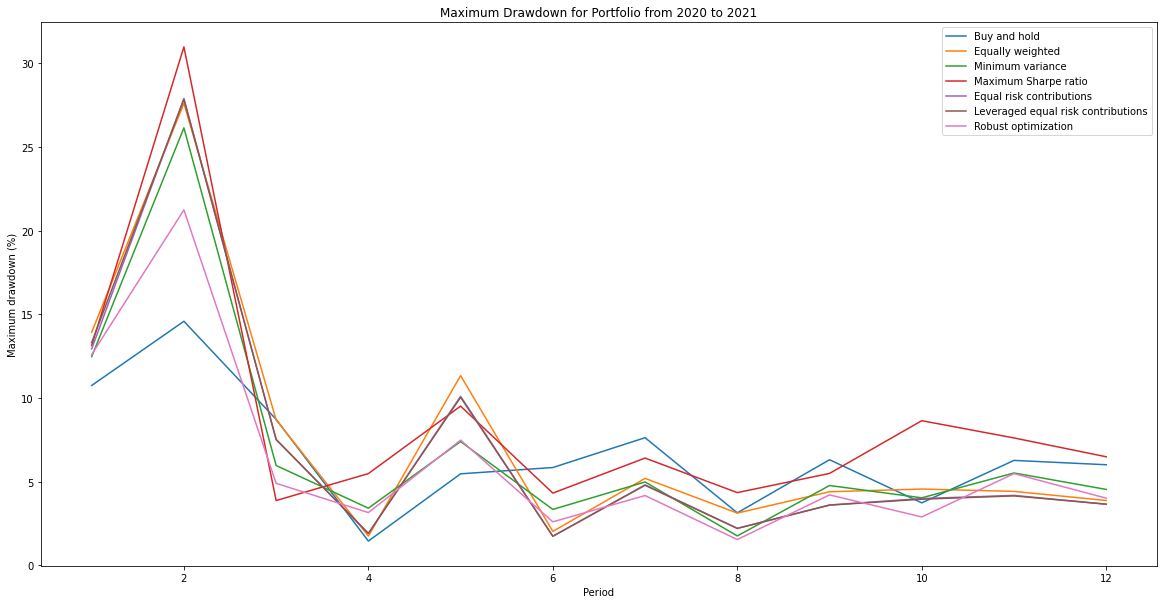

In [44]:
# Maximum drawdown
df_v = pd.DataFrame()
for i in range(7):
    df_v[str(i+1)] = portf_value[i].flatten()

df_l = []
index_ar = [[0,40],[41,82],[83,124],[125,167],[168,211],[212,252],[253,291],[292,334],[335,376],[377,419],[420,462],[463,504]]
for i in range(12):
    df_l.append(df_v.loc[index_ar[i][0]:index_ar[i][1]])

maxDD_array = []
for i in range(12):
    periodArray = []
    for j in range(7):
        dfBuffer = ((df_l[i][str(j+1)] - df_l[i][str(j+1)].expanding().max()) / df_l[i][str(j+1)].expanding().max())*100
        dfBuffer = dfBuffer.abs()
        bufferVal = dfBuffer.max()
        periodArray.append(bufferVal)
    maxDD_array.append(periodArray)
    
df_max = pd.DataFrame()
for i in range(12):
    df_max[i+1] = maxDD_array[i] 
df_max = df_max.transpose()
df_max = df_max.rename(columns={0: "Buy and hold", 1: "Equally weighted", 2: "Minimum variance", 3: "Maximum Sharpe ratio", 4: "Equal risk contributions", 5: "Leveraged equal risk contributions", 6: "Robust optimization"})

df_max.plot(figsize=(20,10))
plt.title('Maximum Drawdown for Portfolio from 2020 to 2021')
plt.xlabel('Period')
plt.ylabel('Maximum drawdown (%)')
plt.show()

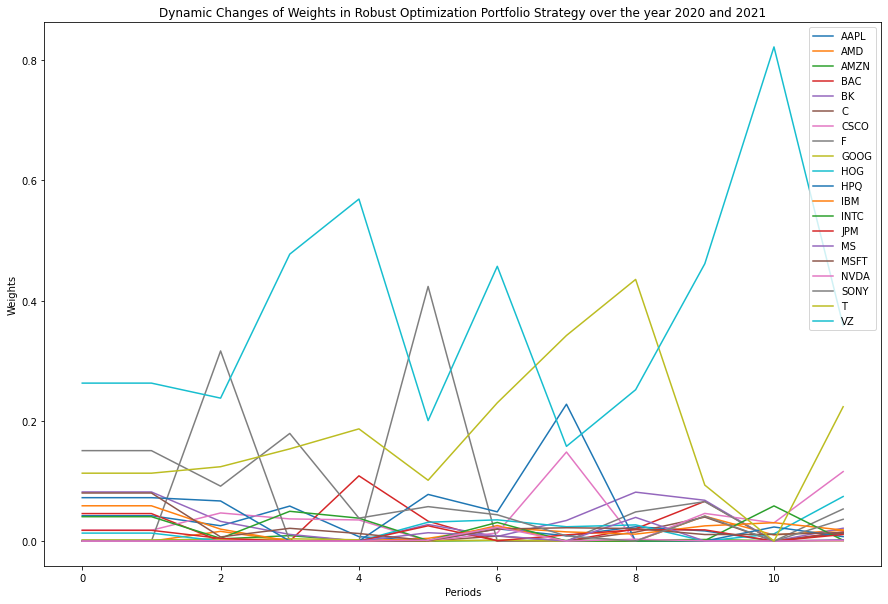

In [48]:
# Dynamic changes for strategy 7
stocks = df.iloc[:, 1:].columns # Get stock names

# Each period
w_robust= []
for period in range(1, N_periods+1):
    w_robust.append(x[6, period-1]/sum(x[6, period-1]))

df_r= pd.DataFrame(w_robust, columns=stocks)
#plot
df_r.plot(figsize=(15,10))
plt.title('Dynamic Changes of Weights in Robust Optimization Portfolio Strategy over the year 2020 and 2021')
plt.legend(loc='upper right')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.show()

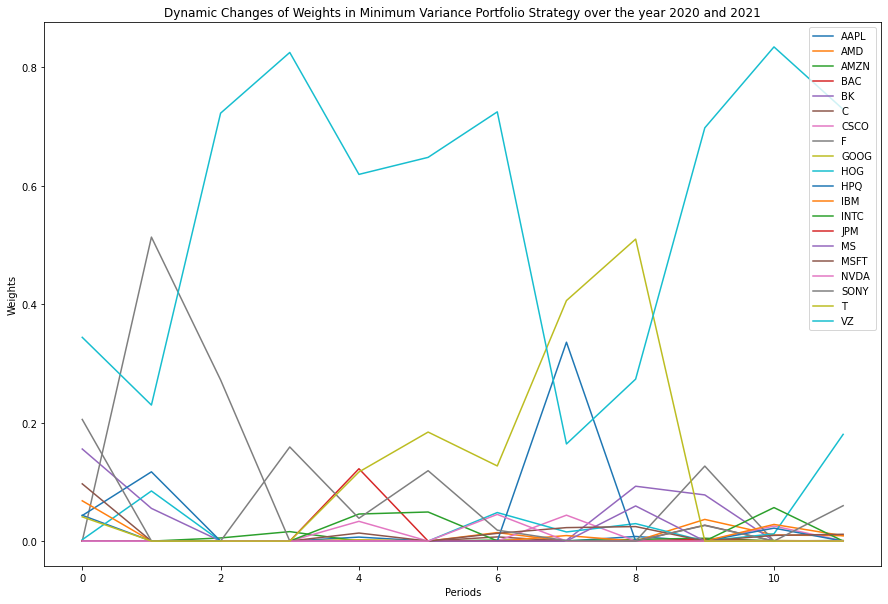

In [49]:
# Min-variance
stocks = df.iloc[:, 1:].columns # Get stock names

# Each period
w_minVar = []
for period in range(1, N_periods+1):
    w_minVar.append(x[2, period-1]/sum(x[2, period-1]))

df2= pd.DataFrame(w_minVar, columns=stocks)
#plot
df2.plot(figsize=(15,10))
plt.title('Dynamic Changes of Weights in Minimum Variance Portfolio Strategy over the year 2020 and 2021')
plt.legend(loc='upper right')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.show()


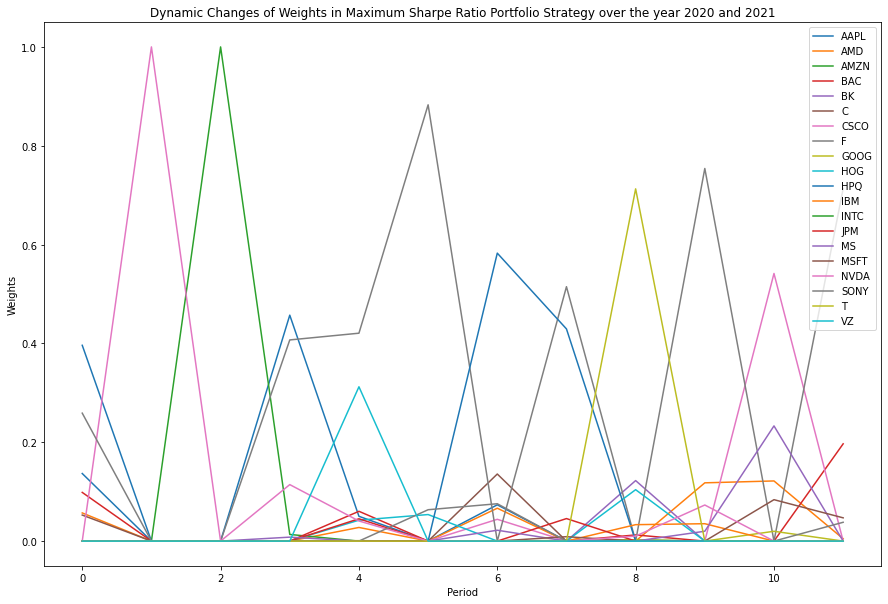

In [50]:
# Maximize Sharpe Ratio strategy 
stocks = df.iloc[:, 1:].columns # Get stock names

w_SR = []
for period in range(1, N_periods+1):
    w_SR.append(x[3, period-1]/sum(x[3, period-1]))
df3 = pd.DataFrame(w_SR, columns=stocks)
df3.plot(figsize=(15,10))
plt.title('Dynamic Changes of Weights in Maximum Sharpe Ratio Portfolio Strategy over the year 2020 and 2021')
plt.legend(loc='upper right')
plt.xlabel('Period')
plt.ylabel('Weights')
plt.show()

Discussion see report

### 3.Test your trading strategies for years 2008 and 2009

In [52]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
        
      while cash[strategy, period-1] < 0:
            # total asset before balancing
            total_asset = np.dot(cur_prices, curr_positions) + curr_cash
            # current weight
            weight = x[strategy][period-1]/np.sum(x[strategy][period-1])
            cash_balance = abs(cash[strategy, period-1])*weight
            x[strategy][period-1] = x[strategy][period-1]- np.ceil(cash_balance/cur_prices) # round up
            # new transaction fee
            tran_fee_new = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = total_asset - np.dot(cur_prices,x[strategy, period-1]) - tran_fee_new
            
        # Compute portfolio value
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381649.89, value end = $ 326929.57
  Strategy "Mininum Variance Portfolio", value begin = $ 383262.49, value end = $ 327144.09
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381848.69, value end = $ 329229.03
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 381237.14, value end = $ 323081.49
  Strategy "Robust Optimization Portfolio", value begin = $ 382119.84, value end = $ 324780.73

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 322097.69, value end = $ 354821.22
  Strategy "Mininum

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 185539.21, value end = $ 209901.43
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 330130.57, value end = $ 369317.40
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 327377.44, value end = $ 366178.56
  Strategy "Robust Optimization Portfolio", value begin = $ 316474.35, value end = $ 353822.36


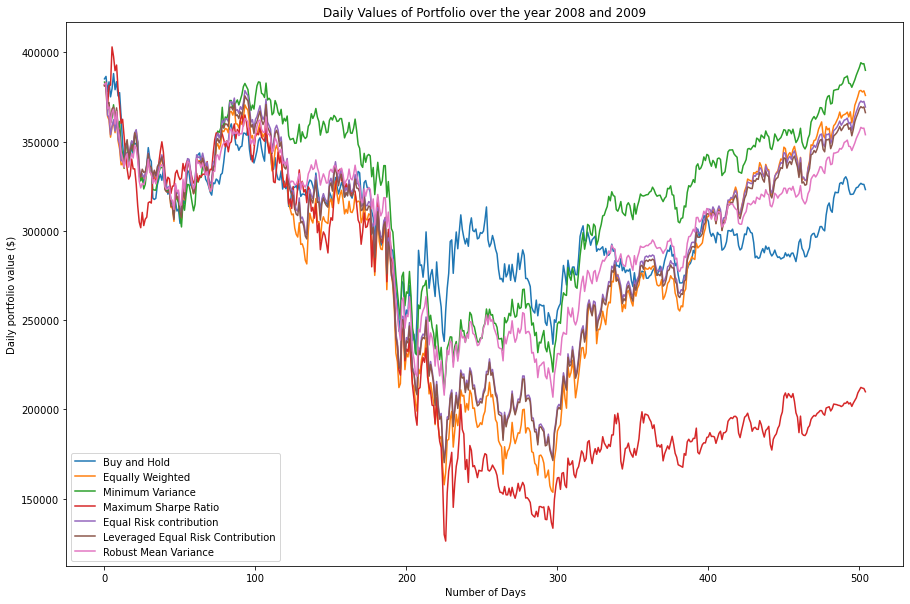

In [53]:
#Plot the daily value of the portfolio
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(portf_value[0], label='Buy and Hold')
ax.plot(portf_value[1], label='Equally Weighted')
ax.plot(portf_value[2], label='Minimum Variance')
ax.plot(portf_value[3], label='Maximum Sharpe Ratio')
ax.plot(portf_value[4],label='Equal Risk contribution')
ax.plot(portf_value[5],label='Leveraged Equal Risk Contribution')
ax.plot(portf_value[6],label='Robust Mean Variance')
ax.set_title('Daily Values of Portfolio over the year 2008 and 2009')
ax.set_xlabel('Number of Days')
ax.set_ylabel('Daily portfolio value ($)')
ax.legend()
plt.show()

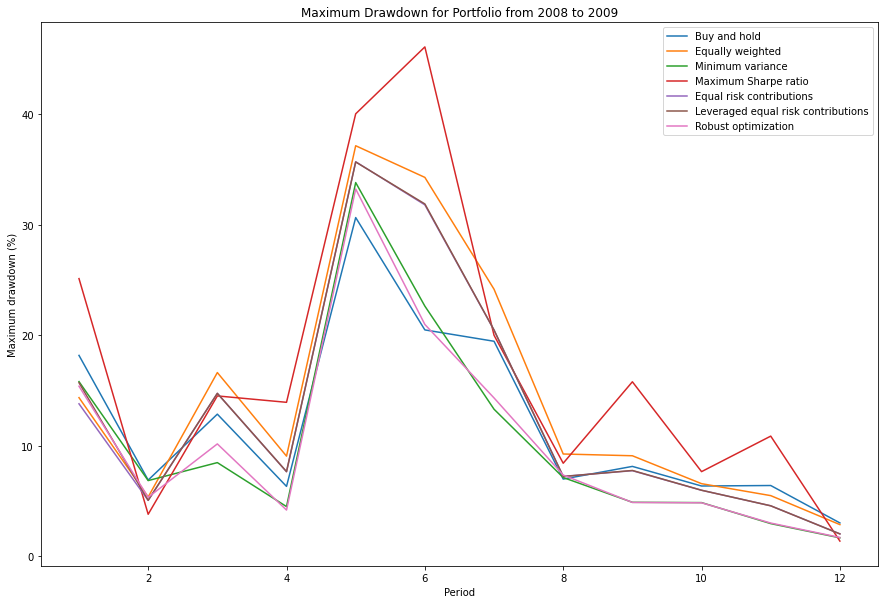

In [58]:
# Maximum drawdown
df_v = pd.DataFrame()
for i in range(7):
    df_v[str(i+1)] = portf_value[i].flatten()

df_l = []
index_ar = [[0,40],[41,82],[83,124],[125,167],[168,211],[212,252],[253,291],[292,334],[335,376],[377,419],[420,462],[463,504]]
for i in range(12):
    df_l.append(df_v.loc[index_ar[i][0]:index_ar[i][1]])

maxDD_array = []
for i in range(12):
    periodArray = []
    for j in range(7):
        dfBuffer = ((df_l[i][str(j+1)] - df_l[i][str(j+1)].expanding().max()) / df_l[i][str(j+1)].expanding().max())*100
        dfBuffer = dfBuffer.abs()
        bufferVal = dfBuffer.max()
        periodArray.append(bufferVal)
    maxDD_array.append(periodArray)
    
df_max = pd.DataFrame()
for i in range(12):
    df_max[i+1] = maxDD_array[i] 
df_max = df_max.transpose()
df_max = df_max.rename(columns={0: "Buy and hold", 1: "Equally weighted", 2: "Minimum variance", 3: "Maximum Sharpe ratio", 4: "Equal risk contributions", 5: "Leveraged equal risk contributions", 6: "Robust optimization"})

df_max.plot(figsize=(15,10))
plt.title('Maximum Drawdown for Portfolio from 2008 to 2009')
plt.xlabel('Period')
plt.ylabel('Maximum drawdown (%)')
plt.show()

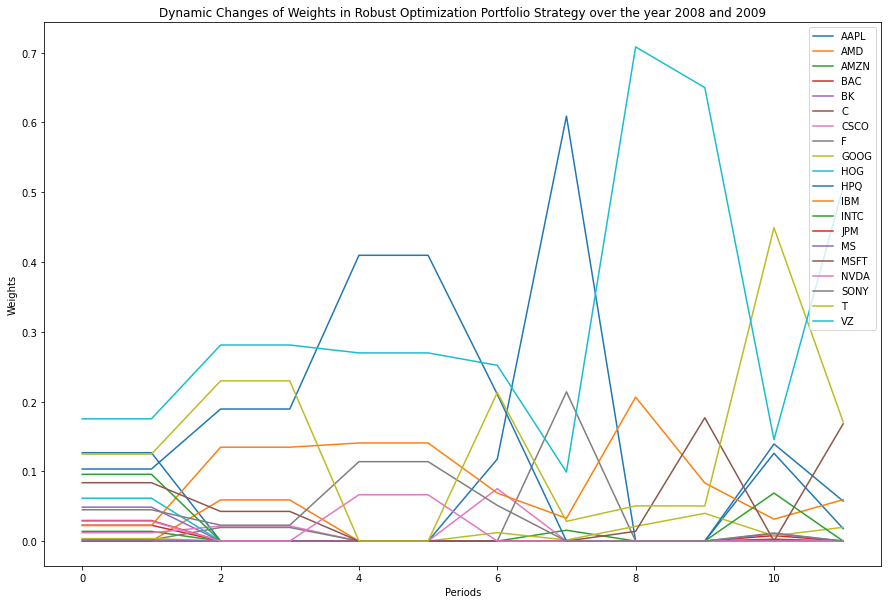

In [59]:
# Dynamic changes for strategy 7
stocks = df.iloc[:, 1:].columns # Get stock names

# Each period
w_robust= []
for period in range(1, N_periods+1):
    w_robust.append(x[6, period-1]/sum(x[6, period-1]))

df_r= pd.DataFrame(w_robust, columns=stocks)
#plot
df_r.plot(figsize=(15,10))
plt.title('Dynamic Changes of Weights in Robust Optimization Portfolio Strategy over the year 2008 and 2009')
plt.legend(loc='upper right')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.show()

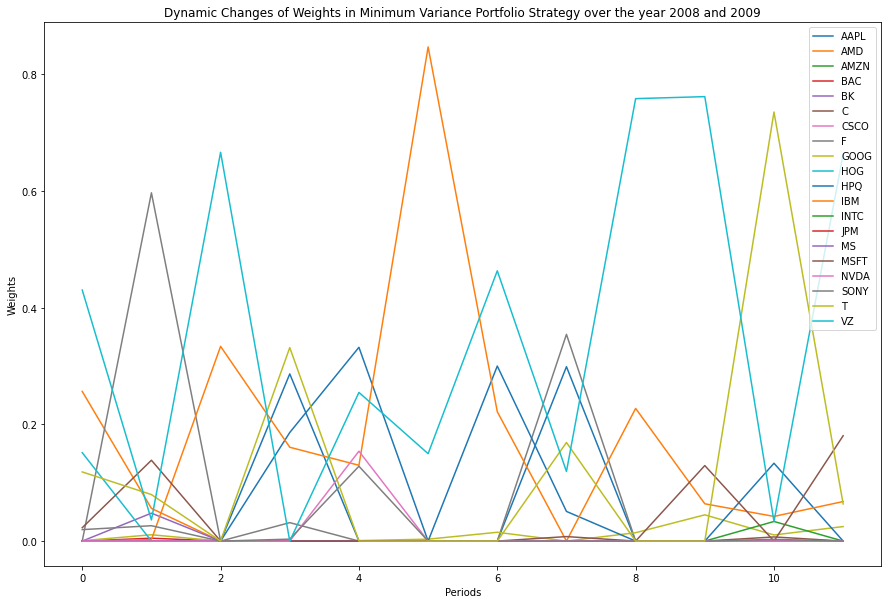

In [60]:
# Min-variance
stocks = df.iloc[:, 1:].columns # Get stock names

# Each period
w_minVar = []
for period in range(1, N_periods+1):
    w_minVar.append(x[2, period-1]/sum(x[2, period-1]))

df2= pd.DataFrame(w_minVar, columns=stocks)
#plot
df2.plot(figsize=(15,10))
plt.title('Dynamic Changes of Weights in Minimum Variance Portfolio Strategy over the year 2008 and 2009')
plt.legend(loc='upper right')
plt.xlabel('Periods')
plt.ylabel('Weights')
plt.show()

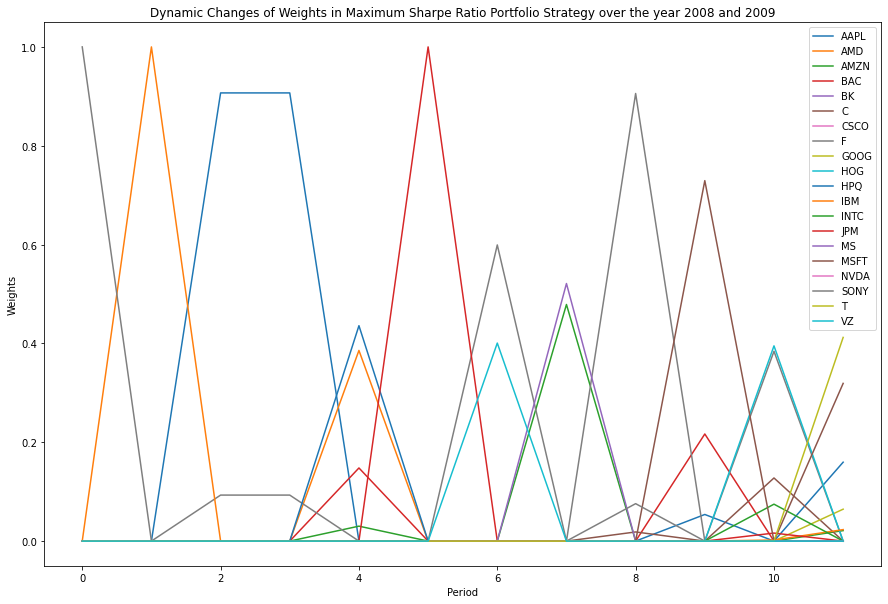

In [61]:
# Maximize Sharpe Ratio strategy 
stocks = df.iloc[:, 1:].columns # Get stock names

w_SR = []
for period in range(1, N_periods+1):
    w_SR.append(x[3, period-1]/sum(x[3, period-1]))
df3 = pd.DataFrame(w_SR, columns=stocks)
df3.plot(figsize=(15,10))
plt.title('Dynamic Changes of Weights in Maximum Sharpe Ratio Portfolio Strategy over the year 2008 and 2009')
plt.legend(loc='upper right')
plt.xlabel('Period')
plt.ylabel('Weights')
plt.show()

 Discussion see report

### 4. Test your trading strategies for year 2022

In [66]:
# Input file
input_file_prices = 'Daily_closing_prices2022.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2021 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2021
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
N_strat = 7  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 22:
       cur_year  = 22 + math.floor(period/7)
   else:
       cur_year  = 2022 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      while cash[strategy, period-1] < 0:
            # total asset before balancing
            total_asset = np.dot(cur_prices, curr_positions) + curr_cash
            # current weight
            weight = x[strategy][period-1]/np.sum(x[strategy][period-1])
            cash_balance = abs(cash[strategy, period-1])*weight
            x[strategy][period-1] = x[strategy][period-1]- np.ceil(cash_balance/cur_prices) # round up
            # new transaction fee
            tran_fee_new = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = total_asset - np.dot(cur_prices,x[strategy, period-1]) - tran_fee_new
            
      # Compute portfolio value
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################


Initial portfolio value = $ 890077.15


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 890077.15, value end = $ 924072.93
  Strategy "Equally Weighted Portfolio", value begin = $ 881997.57, value end = $ 802549.65
  Strategy "Mininum Variance Portfolio", value begin = $ 885873.66, value end = $ 863328.94
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 881222.74, value end = $ 800309.12
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 882721.54, value end = $ 817347.20
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 881302.55, value end = $ 800648.23
  Strategy "Robust Optimization Portfolio", value begin = $ 883675.91, value end = $ 828053.68

Period 2: start date 03/01/2022, end date 04/29/2022
  Strategy "Buy and Hold", value begin = $ 921940.14, value end = $ 807230.89
  Strategy "Equally Weighted Portfolio", value begin = $ 783067.12, value end = $ 705796.90
  Strategy "Mininum

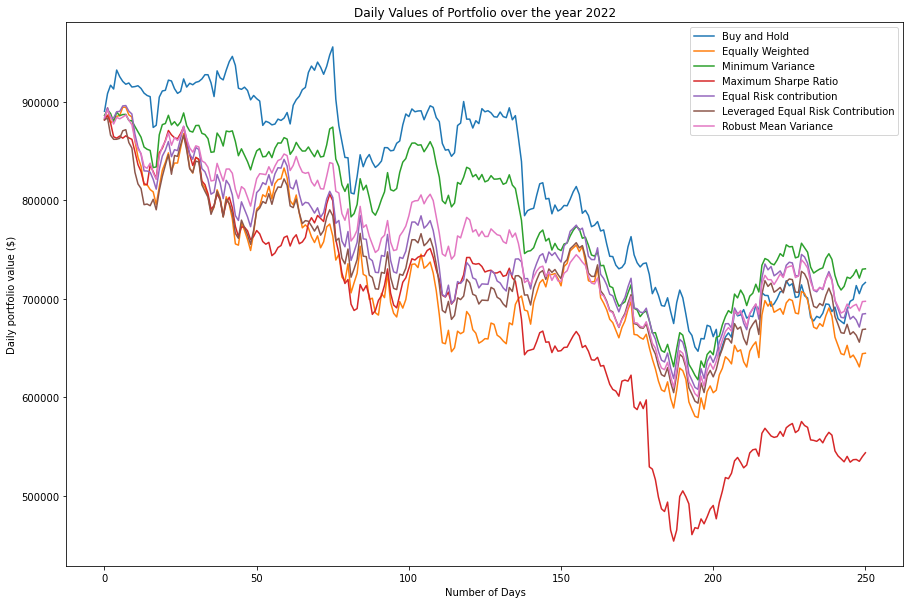

In [64]:
#Plot the daily value of the portfolio
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(portf_value[0], label='Buy and Hold')
ax.plot(portf_value[1], label='Equally Weighted')
ax.plot(portf_value[2], label='Minimum Variance')
ax.plot(portf_value[3], label='Maximum Sharpe Ratio')
ax.plot(portf_value[4],label='Equal Risk contribution')
ax.plot(portf_value[5],label='Leveraged Equal Risk Contribution')
ax.plot(portf_value[6],label='Robust Mean Variance')
ax.set_title('Daily Values of Portfolio over the year 2022')
ax.set_xlabel('Number of Days')
ax.set_ylabel('Daily portfolio value ($)')
ax.legend()
plt.show()

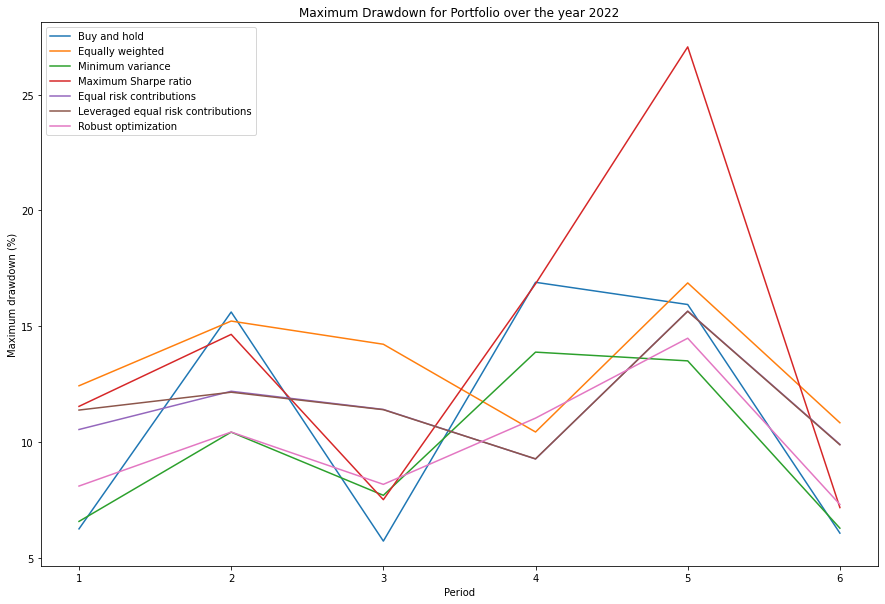

In [65]:
# Maximum drawdown
df_v = pd.DataFrame()
for i in range(7):
    df_v[str(i+1)] = portf_value[i].flatten()

df_l = []
index_ar = [[0,40],[41,82],[83,124],[125,167],[168,211],[212,252],[253,291],[292,334],[335,376],[377,419],[420,462],[463,504]]
for i in range(12):
    df_l.append(df_v.loc[index_ar[i][0]:index_ar[i][1]])

maxDD_array = []
for i in range(12):
    periodArray = []
    for j in range(7):
        dfBuffer = ((df_l[i][str(j+1)] - df_l[i][str(j+1)].expanding().max()) / df_l[i][str(j+1)].expanding().max())*100
        dfBuffer = dfBuffer.abs()
        bufferVal = dfBuffer.max()
        periodArray.append(bufferVal)
    maxDD_array.append(periodArray)
    
df_max = pd.DataFrame()
for i in range(12):
    df_max[i+1] = maxDD_array[i] 
df_max = df_max.transpose()
df_max = df_max.rename(columns={0: "Buy and hold", 1: "Equally weighted", 2: "Minimum variance", 3: "Maximum Sharpe ratio", 4: "Equal risk contributions", 5: "Leveraged equal risk contributions", 6: "Robust optimization"})

df_max.plot(figsize=(15,10))
plt.title('Maximum Drawdown for Portfolio over the year 2022')
plt.xlabel('Period')
plt.ylabel('Maximum drawdown (%)')
plt.show()

Discussion see report